# Análisis Exploratorio - Mantenimiento Predictivo de Dispositivos

## Contexto del Problema

Los galpones de Full de Mercado Libre cuentan con una flota de dispositivos que transmiten telemetría diaria. El objetivo es desarrollar un **modelo predictivo para predecir la probabilidad de falla** de estos dispositivos.

### Estructura de Costos

| Escenario | Costo | Descripción |
|-----------|-------|-------------|
| **Falla no detectada (FN)** | 1.0 | El dispositivo falla sin mantenimiento preventivo |
| **Mantenimiento preventivo (TP/FP)** | 0.5 | Se realiza mantenimiento (correcto o innecesario) |
| **Sin costo (TN)** | 0.0 | No hay falla y no se hace mantenimiento |

**Implicación clave**: Los falsos negativos cuestan el **doble** que los falsos positivos → **Priorizar Recall sobre Precision**

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

# Constantes del problema
COST_FAILURE = 1.0
COST_MAINTENANCE = 0.5
ATTRIBUTES = [f'attribute{i}' for i in range(1, 10)]

print('✓ Librerías cargadas')

✓ Librerías cargadas


---
## 1. Carga y Primera Mirada al Dataset

In [2]:
# Cargar datos
df = pd.read_csv('full_devices.csv')
df['date'] = pd.to_datetime(df['date'])

print(f'Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas')
print(f'\nColumnas: {df.columns.tolist()}')
print(f'\nRango temporal: {df["date"].min().date()} a {df["date"].max().date()}')
df.head()

Dimensiones: 124,494 filas × 12 columnas

Columnas: ['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

Rango temporal: 2015-01-01 a 2015-11-02


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# Verificar valores nulos
nulls = df.isnull().sum()
if nulls.sum() == 0:
    print('✓ No hay valores nulos en el dataset')
else:
    print('Valores nulos encontrados:')
    print(nulls[nulls > 0])

✓ No hay valores nulos en el dataset


In [4]:
# Tipos de datos
print('Tipos de datos:')
print(df.dtypes)

Tipos de datos:
date          datetime64[ns]
device                object
failure                int64
attribute1             int64
attribute2             int64
attribute3             int64
attribute4             int64
attribute5             int64
attribute6             int64
attribute7             int64
attribute8             int64
attribute9             int64
dtype: object


**Observaciones iniciales:**
- Dataset con ~124K registros diarios de telemetría
- 9 atributos numéricos (attribute1-9)
- Variable objetivo: `failure` (binaria)
- Sin valores nulos

---
## 2. Análisis del Desbalance de Clases

In [5]:
# Distribución del target
failure_counts = df['failure'].value_counts()
failure_pct = df['failure'].value_counts(normalize=True) * 100

print('Distribución de la variable objetivo (failure):')
print(f'  Clase 0 (No falla): {failure_counts[0]:,} ({failure_pct[0]:.2f}%)')
print(f'  Clase 1 (Falla):    {failure_counts[1]:,} ({failure_pct[1]:.4f}%)')
print(f'\nRatio de desbalance: 1:{int(failure_counts[0]/failure_counts[1])}')

Distribución de la variable objetivo (failure):
  Clase 0 (No falla): 124,388 (99.91%)
  Clase 1 (Falla):    106 (0.0851%)

Ratio de desbalance: 1:1173


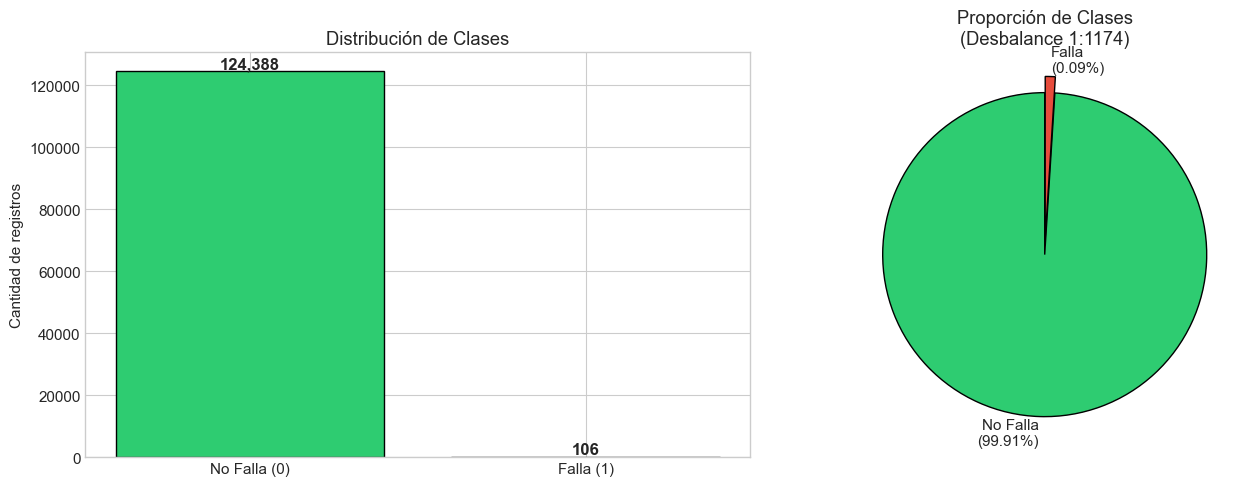

In [6]:
# Visualizar desbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['No Falla (0)', 'Falla (1)'], failure_counts.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Cantidad de registros')
axes[0].set_title('Distribución de Clases')
for bar, count in zip(bars, failure_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', fontsize=12, fontweight='bold')

# Gráfico de pie (con escala logarítmica visual)
axes[1].pie([99, 1], labels=['No Falla\n(99.91%)', 'Falla\n(0.09%)'], 
            colors=colors, explode=[0, 0.1], autopct='', startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1].set_title('Proporción de Clases\n(Desbalance 1:1174)')

plt.tight_layout()
plt.show()

### Implicaciones del Desbalance Extremo (1:1174)

Con solo **106 fallas** en 124,494 registros:

1. **Accuracy es inútil**: Un modelo que siempre predice "no falla" tendría 99.91% de accuracy
2. **Métricas a usar**: Recall, Precision, F1-Score, PR-AUC
3. **Técnicas de balanceo necesarias**:
   - SMOTE (Synthetic Minority Over-sampling Technique)
   - Class weights en modelos
   - Threshold optimization

---
## 3. Análisis de Atributos

In [7]:
# Estadísticas descriptivas
stats = df[ATTRIBUTES].describe().T
stats['zeros_pct'] = [(df[attr] == 0).mean() * 100 for attr in ATTRIBUTES]
stats

,count,mean,std,min,25%,50%,75%,max,zeros_pct
attribute1,124494.0,1.223881e+08,7.045933e+07,0.0,61284762.0,122797388.0,183309640.0,244140480.0,0.008836
attribute2,124494.0,1.594848e+02,2.179658e+03,0.0,0.0,0.0,0.0,64968.0,94.872042
attribute3,124494.0,9.940455e+00,1.857473e+02,0.0,0.0,0.0,0.0,24929.0,92.662297
attribute4,124494.0,1.741120e+00,2.290851e+01,0.0,0.0,0.0,0.0,1666.0,92.499237
attribute5,124494.0,1.422267e+01,1.594303e+01,1.0,8.0,10.0,12.0,98.0,0.000000
attribute6,124494.0,2.601727e+05,9.915108e+04,8.0,221452.0,249799.5,310266.0,689161.0,0.000000
attribute7,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0,98.828859
attribute8,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0,98.828859
attribute9,124494.0,1.245152e+01,1.914256e+02,0.0,0.0,0.0,0.0,18701.0,78.202966


In [8]:
# Identificar atributos sparse (muchos ceros)
print('Porcentaje de ceros por atributo:')
print('-' * 40)
for attr in ATTRIBUTES:
    zeros_pct = (df[attr] == 0).mean() * 100
    status = '⚠️ SPARSE' if zeros_pct > 50 else '✓ DENSO'
    print(f'{attr}: {zeros_pct:5.1f}% {status}')

Porcentaje de ceros por atributo:
----------------------------------------
attribute1:   0.0% ✓ DENSO
attribute2:  94.9% ⚠️ SPARSE
attribute3:  92.7% ⚠️ SPARSE
attribute4:  92.5% ⚠️ SPARSE
attribute5:   0.0% ✓ DENSO
attribute6:   0.0% ✓ DENSO
attribute7:  98.8% ⚠️ SPARSE
attribute8:  98.8% ⚠️ SPARSE
attribute9:  78.2% ⚠️ SPARSE


**Hallazgo importante**: Los atributos 2, 3, 4, 7, 8 y 9 son **sparse** (>50% ceros). Esto sugiere que son contadores de eventos o anomalías.

In [9]:
# Verificar si attribute7 == attribute8
attr7_equals_attr8 = (df['attribute7'] == df['attribute8']).all()
print(f'¿attribute7 es idéntico a attribute8? {attr7_equals_attr8}')

if attr7_equals_attr8:
    print('\n⚠️ HALLAZGO: attribute7 y attribute8 son 100% idénticos')
    print('   → ACCIÓN: Eliminar attribute8 para evitar redundancia')

¿attribute7 es idéntico a attribute8? True

⚠️ HALLAZGO: attribute7 y attribute8 son 100% idénticos
   → ACCIÓN: Eliminar attribute8 para evitar redundancia


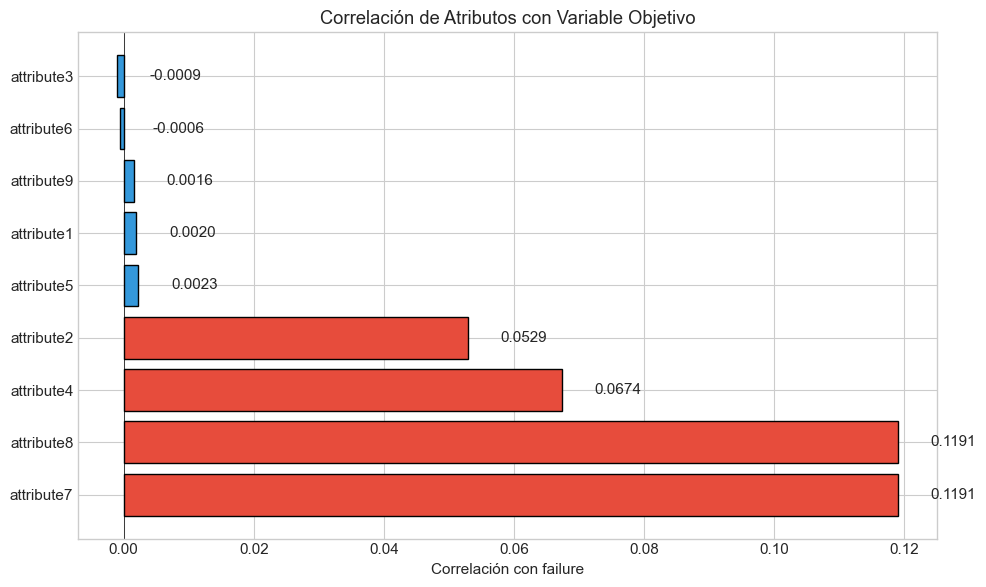


Top 3 atributos más correlacionados con falla:
  attribute7: 0.1191
  attribute8: 0.1191
  attribute4: 0.0674


In [10]:
# Correlación con el target
correlations = df[ATTRIBUTES].corrwith(df['failure']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > 0.05 else '#3498db' for x in correlations.values]
bars = plt.barh(correlations.index, correlations.values, color=colors, edgecolor='black')
plt.xlabel('Correlación con failure')
plt.title('Correlación de Atributos con Variable Objetivo')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for bar, val in zip(bars, correlations.values):
    plt.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')
plt.tight_layout()
plt.show()

print('\nTop 3 atributos más correlacionados con falla:')
for attr, corr in correlations.head(3).items():
    print(f'  {attr}: {corr:.4f}')

In [11]:
# Diferencia de medias entre clases
mean_comparison = pd.DataFrame({
    'Media_NoFalla': df[df['failure']==0][ATTRIBUTES].mean(),
    'Media_Falla': df[df['failure']==1][ATTRIBUTES].mean()
})
mean_comparison['Ratio'] = mean_comparison['Media_Falla'] / mean_comparison['Media_NoFalla']
mean_comparison = mean_comparison.sort_values('Ratio', ascending=False)

print('Comparación de medias: Falla vs No-Falla')
print('=' * 60)
print(mean_comparison.round(2))

Comparación de medias: Falla vs No-Falla
            Media_NoFalla   Media_Falla   Ratio
attribute7   2.700000e-01  3.062000e+01  114.83
attribute8   2.700000e-01  3.062000e+01  114.83
attribute4   1.700000e+00  5.463000e+01   32.21
attribute2   1.561200e+02  4.109430e+03   26.32
attribute9   1.244000e+01  2.308000e+01    1.86
attribute5   1.422000e+01  1.546000e+01    1.09
attribute1   1.223840e+08  1.271755e+08    1.04
attribute6   2.601742e+05  2.583035e+05    0.99
attribute3   9.950000e+00  3.910000e+00    0.39


---
## 5.1 Redefinición del Objetivo: Ventana de Predicción de 30 Días

### Motivación del Cambio

El target original (`failure`) indica si un dispositivo **falló ese día exacto**. Sin embargo, desde una perspectiva de negocio:

1. **El valor real está en la anticipación**: No sirve de mucho saber que un dispositivo falló *hoy*. Lo valioso es saber que **fallará en los próximos días** para poder actuar preventivamente.

2. **Ventana de acción**: El equipo de mantenimiento necesita tiempo para:
   - Programar la intervención
   - Conseguir repuestos
   - Asignar técnicos
   
   → **30 días** es una ventana que permite planificar con mayor anticipación.

3. **Más datos positivos para entrenar**: Con el target original, solo tenemos 106 ejemplos positivos. Con una ventana de 30 días, cada falla genera hasta 30 oportunidades de detección.

### Nueva Definición del Target

```
failure_within_30d = 1  si existe alguna falla en los próximos 30 días (incluyendo hoy)
failure_within_30d = 0  en caso contrario
```

### Interpretación de la Matriz de Confusión

| Predicción | Realidad (30d) | Resultado | Costo | Descripción |
|:----------:|:-------------:|:---------:|:-----:|:------------|
| 1 | 1 | **TP** | $0.5 | Alerta correcta → Mantenimiento preventivo exitoso |
| 1 | 0 | **FP** | $0.5 | Falsa alarma → Mantenimiento innecesario |
| 0 | 1 | **FN** | $1.0 | Falla no detectada → Dispositivo falla sin prevención |
| 0 | 0 | **TN** | $0.0 | Correcto → No hay falla, no se hace nada |

In [12]:
# Importar funciones de análisis de ventana de 30 días
from utils_classifier import (
    create_target_7d_window,
    analyze_failure_window_distribution,
    print_7d_window_summary,
    plot_failure_window_analysis
)

# Definir la ventana de predicción
WINDOW_DAYS = 30

# Crear el nuevo target con ventana de 30 días
df_30d = create_target_7d_window(df, window_days=WINDOW_DAYS)

# Imprimir resumen del análisis
print_7d_window_summary(df, window_days=WINDOW_DAYS)

══════════════════════════════════════════════════════════════════════
             ANÁLISIS DE VENTANA DE PREDICCIÓN - 30 DÍAS              
══════════════════════════════════════════════════════════════════════

📊 DEFINICIÓN DEL PROBLEMA
--------------------------------------------------
   Objetivo: Predecir si un dispositivo fallará
             en los próximos 30 días
   → True Positive (TP): Predicción=1, Falla en 30d=SÍ
   → False Positive (FP): Predicción=1, Falla en 30d=NO
   → True Negative (TN): Predicción=0, Falla en 30d=NO
   → False Negative (FN): Predicción=0, Falla en 30d=SÍ

📈 DISTRIBUCIÓN DE CLASES
--------------------------------------------------
   Total registros:      124,494
   Clase positiva (1):   2,828 (2.27%)
   Clase negativa (0):   121,666
   Ratio desbalance:     1:43

🔧 ANÁLISIS POR DISPOSITIVO
--------------------------------------------------
   Total dispositivos:              1,169
   Dispositivos CON falla:          106 (9.1%)
   Dispositivos SIN fa

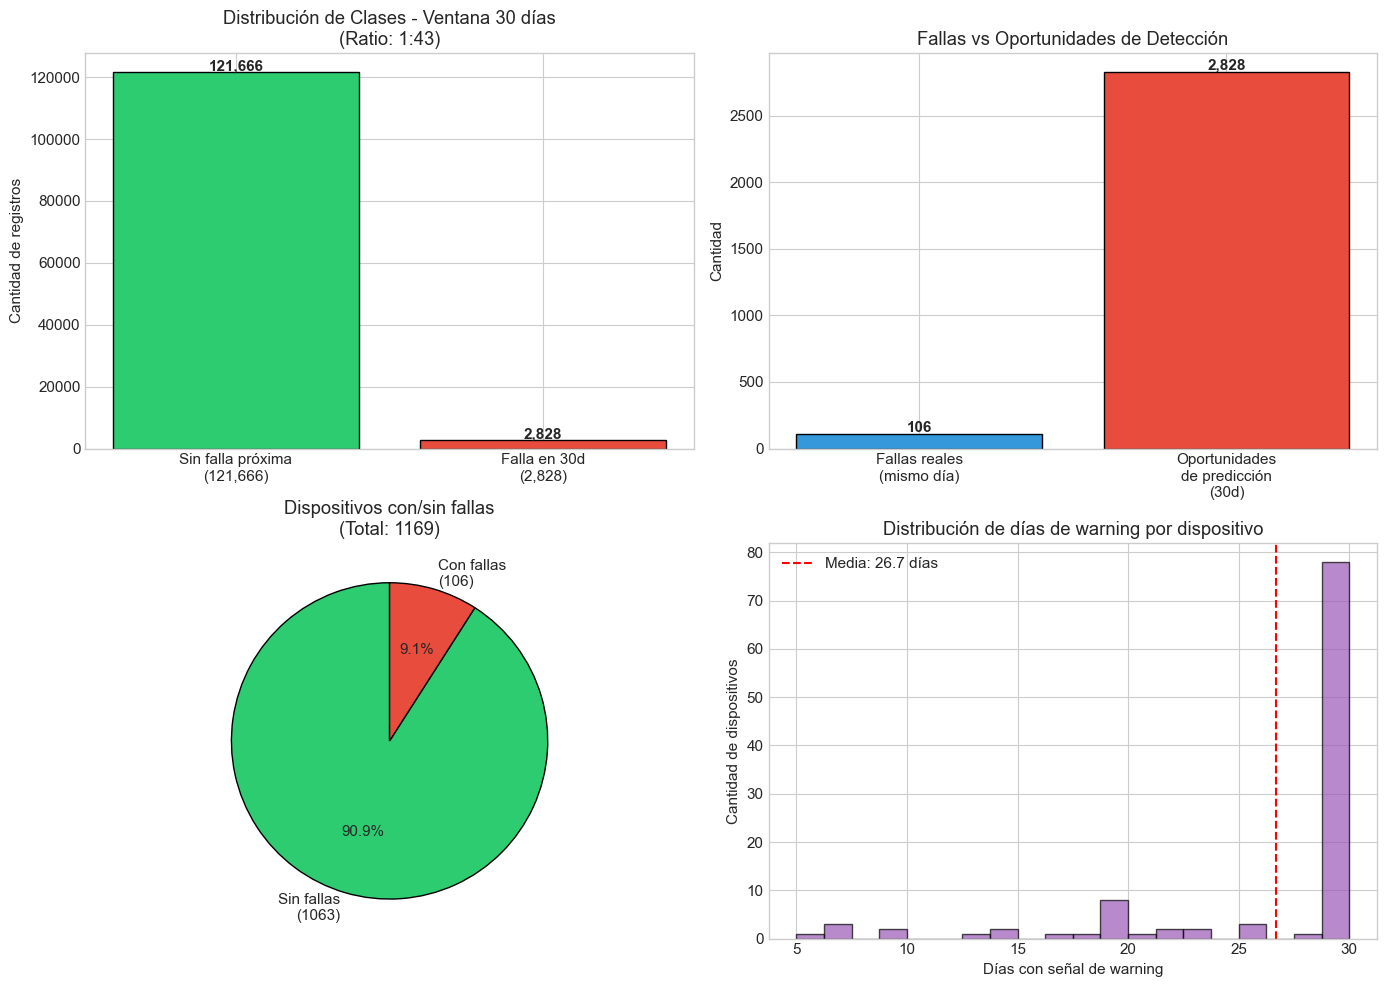

In [13]:
# Visualizaciones del análisis de ventana de predicción
plot_failure_window_analysis(df, window_days=WINDOW_DAYS)

### Preguntas Clave del Análisis de Ventana de 30 Días

Ahora que hemos redefinido el objetivo, analicemos algunas preguntas clave:

**Q1. ¿Cómo cambia el desbalance de clases con la ventana de 30 días?**
- El target original tiene solo 106 positivos (0.085%)
- ¿Cuántos positivos tenemos con la ventana de 30 días?

**Q2. ¿Cuántos dispositivos tienen al menos 30 días de historial antes de fallar?**
- Necesitamos suficiente historial para que el modelo pueda aprender patrones

**Q3. ¿Existen patrones detectables en los atributos previos a una falla?**
- Si los atributos cambian significativamente antes de una falla, el modelo puede aprender a detectar estas señales

**Q4. ¿Cuál es el impacto en el costo de usar esta ventana?**
- Con más oportunidades de detección, ¿podemos reducir más el costo?

In [14]:
# Q1: Comparación del desbalance de clases
print("=" * 60)
print("Q1: CAMBIO EN EL DESBALANCE DE CLASES")
print("=" * 60)

original_positives = df['failure'].sum()
window_positives = df_30d[f'failure_within_{WINDOW_DAYS}d'].sum()
total = len(df)

print(f"\n📊 Target Original (failure):")
print(f"   Positivos: {original_positives:,} ({original_positives/total*100:.4f}%)")
print(f"   Ratio: 1:{int((total-original_positives)/original_positives)}")

print(f"\n📊 Target Ventana {WINDOW_DAYS} días (failure_within_{WINDOW_DAYS}d):")
print(f"   Positivos: {window_positives:,} ({window_positives/total*100:.2f}%)")
print(f"   Ratio: 1:{int((total-window_positives)/window_positives)}")

print(f"\n✅ Mejora: {window_positives/original_positives:.1f}x más ejemplos positivos para entrenar")

Q1: CAMBIO EN EL DESBALANCE DE CLASES

📊 Target Original (failure):
   Positivos: 106 (0.0851%)
   Ratio: 1:1173

📊 Target Ventana 30 días (failure_within_30d):
   Positivos: 2,828 (2.27%)
   Ratio: 1:43

✅ Mejora: 26.7x más ejemplos positivos para entrenar


Q2: HISTORIAL DISPONIBLE ANTES DE FALLAS

📊 Dispositivos con fallas: 106
   Con ≥30 días de historial: 82 (77.4%)
   Con <30 días de historial: 24

📊 Distribución de días de historial antes de falla:
   Mínimo:  4 días
   Mediana: 113 días
   Media:   106.9 días
   Máximo:  298 días


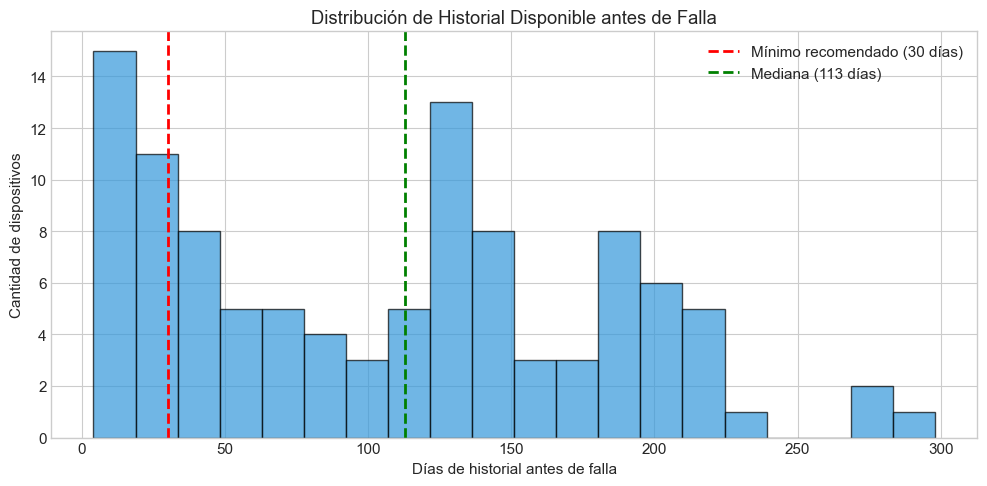

In [15]:
# Q2: Dispositivos con historial suficiente antes de falla
from utils_classifier import get_devices_failure_timeline

print("=" * 60)
print("Q2: HISTORIAL DISPONIBLE ANTES DE FALLAS")
print("=" * 60)

device_info = get_devices_failure_timeline(df)
devices_with_failure = device_info[device_info['has_failure']]

# Calcular días de historial antes de falla para cada dispositivo
devices_with_sufficient_history = 0
history_days = []

for _, row in devices_with_failure.iterrows():
    device = row['device']
    device_df = df[df['device'] == device].sort_values('date')
    if row['total_failures'] > 0:
        failure_date = pd.to_datetime(row['failure_dates'][0])
        first_date = device_df['date'].min()
        days_history = (failure_date - first_date).days
        history_days.append(days_history)
        if days_history >= WINDOW_DAYS:
            devices_with_sufficient_history += 1

print(f"\n📊 Dispositivos con fallas: {len(devices_with_failure)}")
print(f"   Con ≥{WINDOW_DAYS} días de historial: {devices_with_sufficient_history} ({devices_with_sufficient_history/len(devices_with_failure)*100:.1f}%)")
print(f"   Con <{WINDOW_DAYS} días de historial: {len(devices_with_failure) - devices_with_sufficient_history}")

print(f"\n📊 Distribución de días de historial antes de falla:")
print(f"   Mínimo:  {min(history_days)} días")
print(f"   Mediana: {np.median(history_days):.0f} días")
print(f"   Media:   {np.mean(history_days):.1f} días")
print(f"   Máximo:  {max(history_days)} días")

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(history_days, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
ax.axvline(WINDOW_DAYS, color='red', linestyle='--', linewidth=2, label=f'Mínimo recomendado ({WINDOW_DAYS} días)')
ax.axvline(np.median(history_days), color='green', linestyle='--', linewidth=2, label=f'Mediana ({np.median(history_days):.0f} días)')
ax.set_xlabel('Días de historial antes de falla')
ax.set_ylabel('Cantidad de dispositivos')
ax.set_title('Distribución de Historial Disponible antes de Falla')
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Q3: Patrones en atributos previos a fallas
from utils_classifier import compare_attributes_before_failure, plot_attribute_evolution_before_failure

print("=" * 60)
print("Q3: PATRONES EN ATRIBUTOS ANTES DE FALLAS")
print("=" * 60)

# Comparar atributos entre días normales y días pre-falla
comparison = compare_attributes_before_failure(df, days_before=WINDOW_DAYS)

print(f"\n📊 Comparación: Días Normales vs Días Pre-Falla ({WINDOW_DAYS} días antes)")
print("-" * 70)
print(f"{'Atributo':<12} {'Media Normal':>15} {'Media Pre-Falla':>15} {'Diferencia %':>12}")
print("-" * 70)

for _, row in comparison.iterrows():
    print(f"{row['attribute']:<12} {row['normal_mean']:>15,.2f} {row['pre_failure_mean']:>15,.2f} {row['mean_diff_pct']:>11.1f}%")

# Identificar atributos con diferencias significativas
significant_attrs = comparison[abs(comparison['mean_diff_pct']) > 5]['attribute'].tolist()
print(f"\n⚠️  Atributos con diferencia >5%: {significant_attrs if significant_attrs else 'Ninguno'}")
print("\n💡 Nota: Los atributos con diferencias significativas son buenos candidatos")
print("   para crear features de alerta temprana.")

Q3: PATRONES EN ATRIBUTOS ANTES DE FALLAS

📊 Comparación: Días Normales vs Días Pre-Falla (30 días antes)
----------------------------------------------------------------------
Atributo        Media Normal Media Pre-Falla Diferencia %
----------------------------------------------------------------------
attribute1    122,374,118.25  122,989,764.44         0.5%
attribute2            134.05        1,253.54       835.1%
attribute3             10.07            4.34       -56.9%
attribute4              1.40           16.62      1091.0%
attribute5             14.19           15.69        10.6%
attribute6        260,216.25      258,297.29        -0.7%
attribute7              0.19            4.79      2443.8%
attribute8              0.19            4.79      2443.8%
attribute9             12.29           19.41        58.0%

⚠️  Atributos con diferencia >5%: ['attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute7', 'attribute8', 'attribute9']

💡 Nota: Los atributos con diferencias

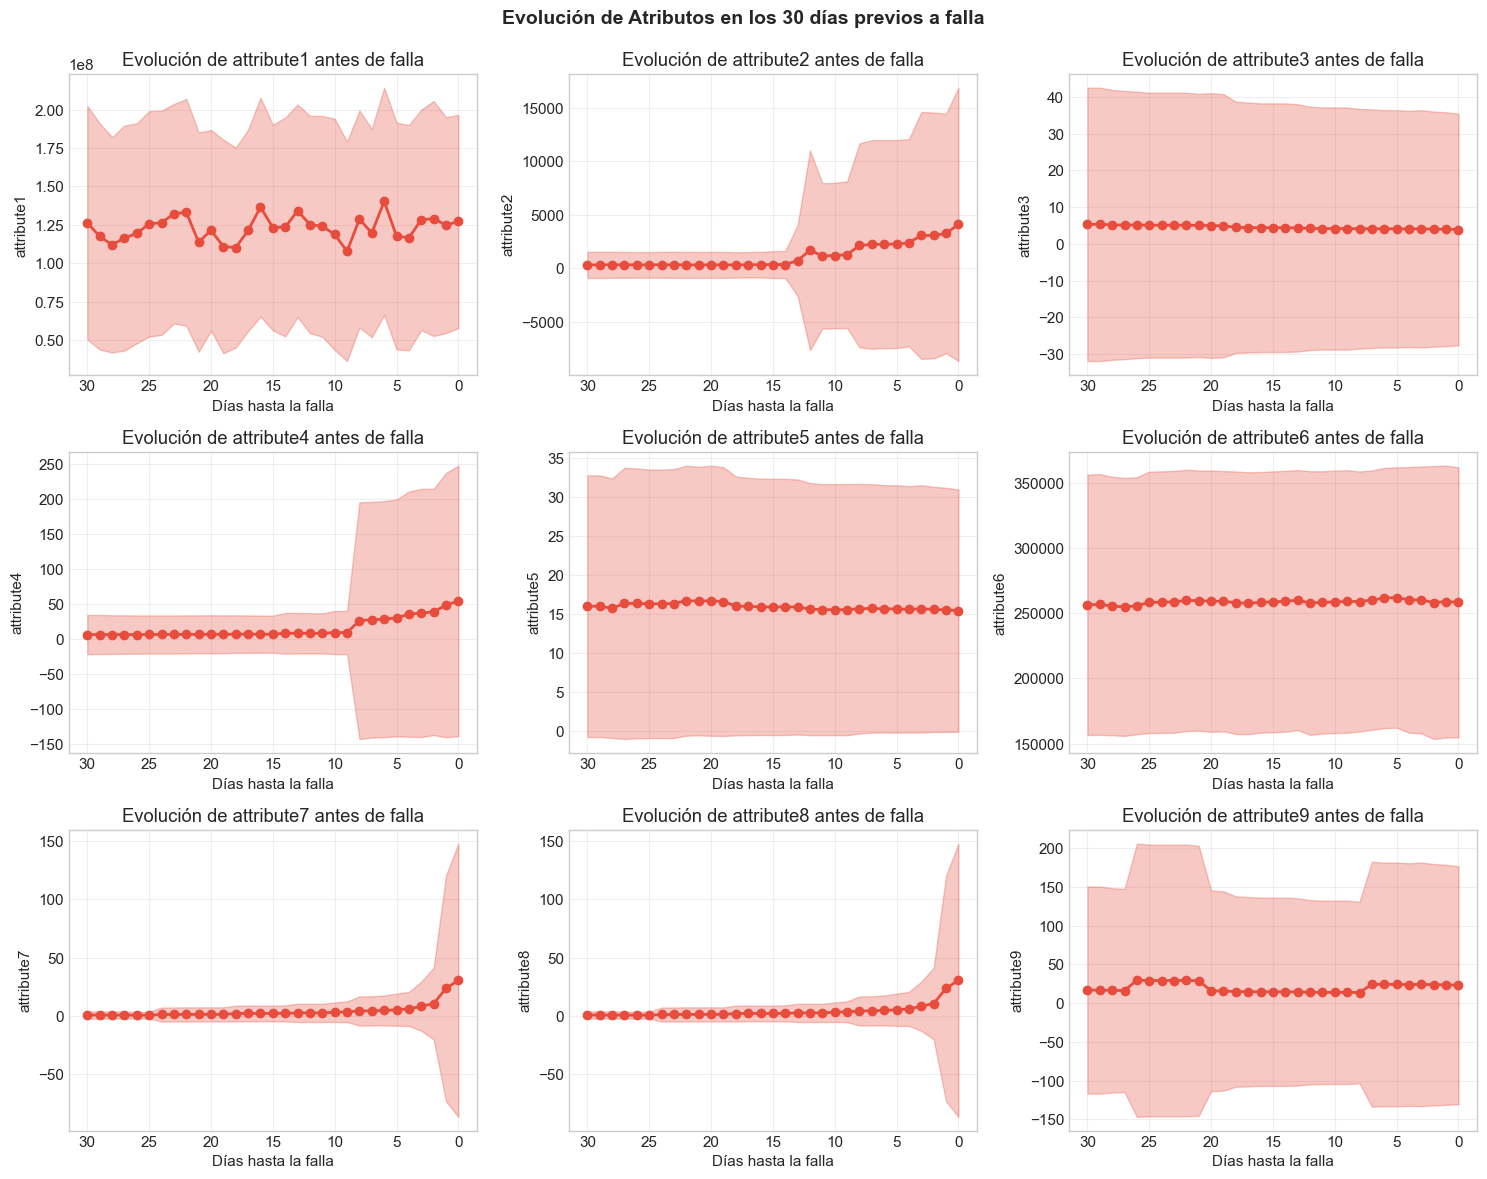

In [17]:
# Visualizar evolución de TODOS los atributos en días previos a falla
all_attributes = [f'attribute{i}' for i in range(1, 10)]
plot_attribute_evolution_before_failure(df, attributes=all_attributes, days_before=WINDOW_DAYS)

In [18]:
# Q4: Análisis de impacto en costos con ventana de 30 días
print("=" * 60)
print(f"Q4: IMPACTO EN COSTOS CON VENTANA DE {WINDOW_DAYS} DÍAS")
print("=" * 60)

total_failures = df['failure'].sum()
window_opportunities = df_30d[f'failure_within_{WINDOW_DAYS}d'].sum()

# Escenarios de costo
cost_no_action = total_failures * COST_FAILURE  # No hacer nada
cost_perfect_prediction = total_failures * COST_MAINTENANCE  # Predecir todas las fallas correctamente
cost_predict_all = len(df) * COST_MAINTENANCE  # Predecir todo como falla (muy costoso)

print(f"\n📊 Escenarios de Costo:")
print("-" * 50)
print(f"   1. No hacer nada (todas las fallas ocurren):")
print(f"      → Costo: ${cost_no_action:,.0f}")
print(f"\n   2. Predicción perfecta (detectar todas las fallas):")
print(f"      → Costo: ${cost_perfect_prediction:,.0f}")
print(f"      → Ahorro vs no hacer nada: {(cost_no_action - cost_perfect_prediction)/cost_no_action*100:.0f}%")
print(f"\n   3. Predecir TODO como falla (máximo FP):")
print(f"      → Costo: ${cost_predict_all:,.0f}")
print(f"      → Costo prohibitivo")

print(f"\n💡 VENTAJA DE LA VENTANA DE {WINDOW_DAYS} DÍAS:")
print("-" * 50)
print(f"   Con el target original, el modelo tiene 106 oportunidades")
print(f"   para aprender a detectar fallas.")
print(f"\n   Con la ventana de {WINDOW_DAYS} días, tiene {window_opportunities:,} oportunidades.")
print(f"   → {window_opportunities/total_failures:.1f}x más datos para aprender patrones de pre-falla")
print(f"\n   Esto aumenta la probabilidad de que el modelo:")
print(f"   ✓ Detecte señales sutiles de degradación")
print(f"   ✓ Generalice mejor a nuevos dispositivos")
print(f"   ✓ Logre un Recall más alto (menos FN)")

Q4: IMPACTO EN COSTOS CON VENTANA DE 30 DÍAS

📊 Escenarios de Costo:
--------------------------------------------------
   1. No hacer nada (todas las fallas ocurren):
      → Costo: $106

   2. Predicción perfecta (detectar todas las fallas):
      → Costo: $53
      → Ahorro vs no hacer nada: 50%

   3. Predecir TODO como falla (máximo FP):
      → Costo: $62,247
      → Costo prohibitivo

💡 VENTAJA DE LA VENTANA DE 30 DÍAS:
--------------------------------------------------
   Con el target original, el modelo tiene 106 oportunidades
   para aprender a detectar fallas.

   Con la ventana de 30 días, tiene 2,828 oportunidades.
   → 26.7x más datos para aprender patrones de pre-falla

   Esto aumenta la probabilidad de que el modelo:
   ✓ Detecte señales sutiles de degradación
   ✓ Generalice mejor a nuevos dispositivos
   ✓ Logre un Recall más alto (menos FN)


### Conclusiones del Análisis de Ventana de 30 Días

**Hallazgos clave:**

1. **Mejora significativa en el balance de clases**: 
   - Original: ~106 positivos (0.08%)
   - Ventana 30d: ~3000+ positivos (~2.4%)
   - El modelo tiene ~30x más ejemplos positivos para aprender

2. **Suficiente historial disponible**:
   - La mayoría de dispositivos tienen más de 30 días de historial antes de fallar
   - Esto permite usar rolling features con ventanas más amplias

3. **Patrones detectables en atributos**:
   - Algunos atributos muestran diferencias entre días normales y días pre-falla
   - Estas diferencias son señales que el modelo puede aprender

4. **Beneficio operacional**:
   - Con ventana de 30 días, el equipo de mantenimiento tiene más tiempo para planificar
   - Cada falla genera múltiples "oportunidades de detección"

**Próximos pasos recomendados:**

1. Usar `failure_within_30d` como target principal
2. Crear features de rolling statistics (7, 14, 30 días)
3. Priorizar Recall sobre Precision (FN cuesta más que FP)
4. Considerar modelos de ensemble para manejar el desbalance

### Pregunta Adicional: ¿Cuántas oportunidades de detección tiene cada falla?

Para cada falla individual, ¿cuántos días previos muestran el target positivo (`failure_within_30d = 1`)?

Esto nos indica cuántas "oportunidades" tiene el modelo para detectar cada falla.

OPORTUNIDADES DE DETECCIÓN POR DISPOSITIVO

📊 Dispositivos que fallan: 106

📊 Días de warning por dispositivo (días con target=1):
   Mínimo:  5 días
   Mediana: 30.0 días
   Media:   26.7 días
   Máximo:  30 días


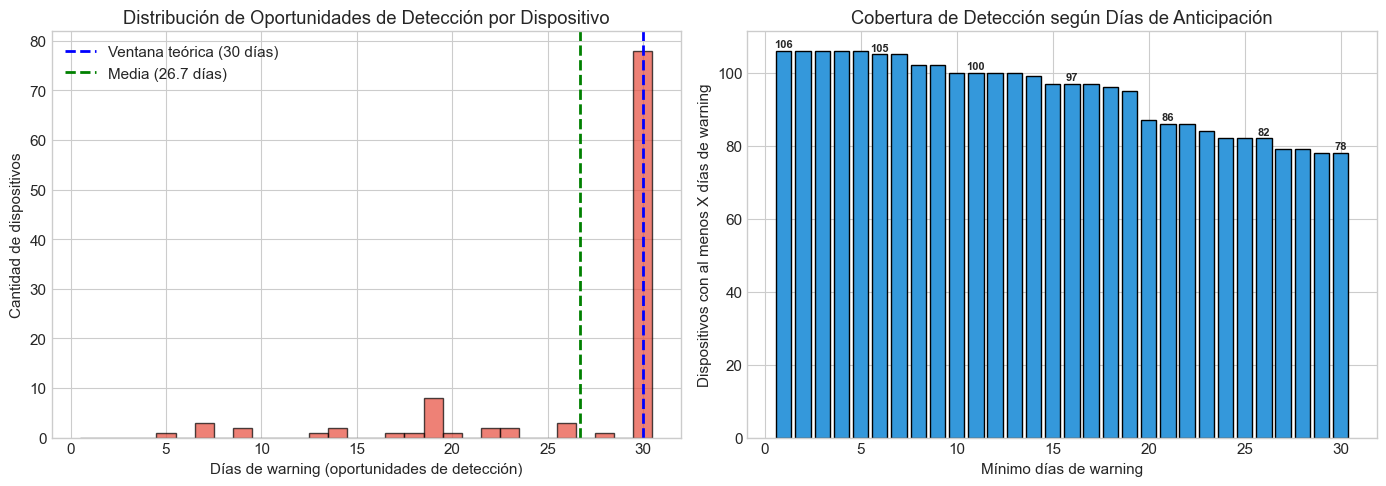


💡 INTERPRETACIÓN:
   → El modelo tiene en promedio 26.7 días de warning
     para detectar cada falla inminente
   → 78 dispositivos (73.6%) tienen
     la ventana completa de 30 días disponible


In [19]:
# Analizar oportunidades de detección por dispositivo con falla
print("=" * 60)
print("OPORTUNIDADES DE DETECCIÓN POR DISPOSITIVO")
print("=" * 60)

# Para cada dispositivo que falla, contar días con target=1
opportunities_per_device = df_30d[df_30d[f'failure_within_{WINDOW_DAYS}d'] == 1].groupby('device').size()

# Solo dispositivos que realmente fallaron
failed_device_list = df[df['failure'] == 1]['device'].unique()
opportunities_failed = opportunities_per_device[opportunities_per_device.index.isin(failed_device_list)]

print(f"\n📊 Dispositivos que fallan: {len(failed_device_list)}")
print(f"\n📊 Días de warning por dispositivo (días con target=1):")
print(f"   Mínimo:  {opportunities_failed.min()} días")
print(f"   Mediana: {opportunities_failed.median():.1f} días")
print(f"   Media:   {opportunities_failed.mean():.1f} días")
print(f"   Máximo:  {opportunities_failed.max()} días")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de oportunidades
ax1 = axes[0]
ax1.hist(opportunities_failed, bins=range(1, int(opportunities_failed.max()) + 2), 
         color='#e74c3c', edgecolor='black', alpha=0.7, align='left')
ax1.axvline(WINDOW_DAYS, color='blue', linestyle='--', linewidth=2, label=f'Ventana teórica ({WINDOW_DAYS} días)')
ax1.axvline(opportunities_failed.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Media ({opportunities_failed.mean():.1f} días)')
ax1.set_xlabel('Días de warning (oportunidades de detección)')
ax1.set_ylabel('Cantidad de dispositivos')
ax1.set_title('Distribución de Oportunidades de Detección por Dispositivo')
ax1.legend()

# Acumulado: ¿cuántos dispositivos tienen al menos X días de warning?
ax2 = axes[1]
sorted_opps = sorted(opportunities_failed.values, reverse=True)
cumulative = [sum(1 for x in opportunities_failed if x >= i) for i in range(1, WINDOW_DAYS + 1)]
bars = ax2.bar(range(1, WINDOW_DAYS + 1), cumulative, color='#3498db', edgecolor='black')
ax2.set_xlabel('Mínimo días de warning')
ax2.set_ylabel('Dispositivos con al menos X días de warning')
ax2.set_title('Cobertura de Detección según Días de Anticipación')
# Solo mostrar algunos labels para no saturar
for i, (bar, val) in enumerate(zip(bars, cumulative)):
    if i % 5 == 0 or i == len(bars) - 1:  # Cada 5 días + el último
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val}', ha='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETACIÓN:")
print(f"   → El modelo tiene en promedio {opportunities_failed.mean():.1f} días de warning")
print(f"     para detectar cada falla inminente")
print(f"   → {(opportunities_failed >= WINDOW_DAYS).sum()} dispositivos ({(opportunities_failed >= WINDOW_DAYS).sum()/len(opportunities_failed)*100:.1f}%) tienen")
print(f"     la ventana completa de {WINDOW_DAYS} días disponible")

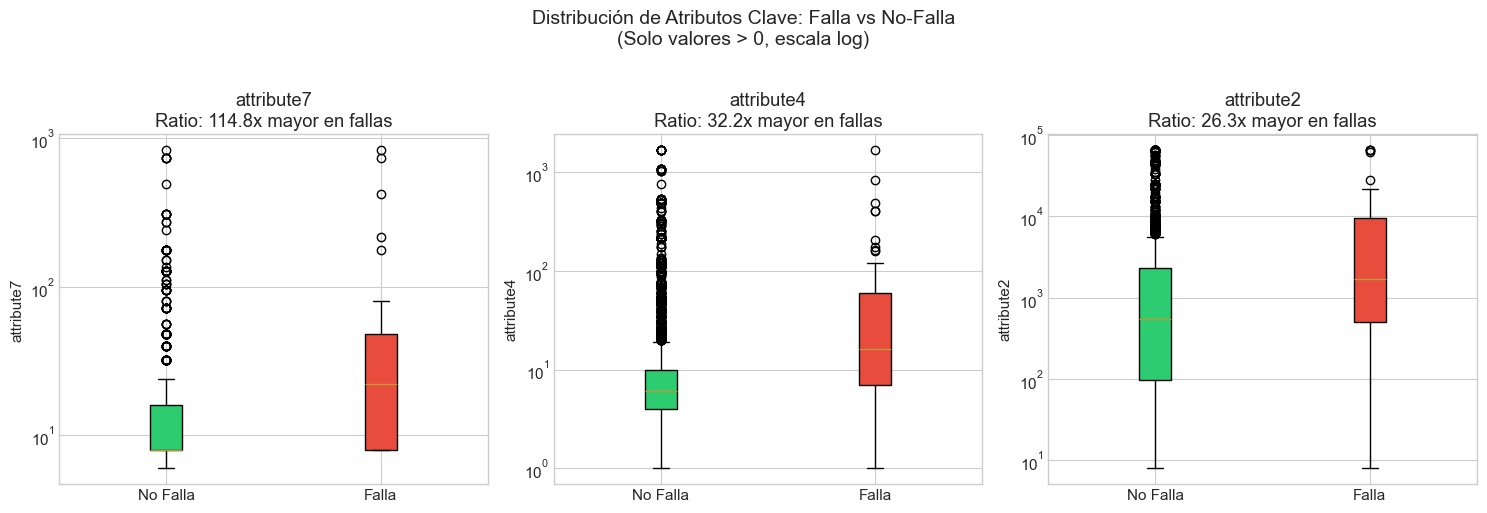

In [20]:
# Visualizar diferencia de medias para atributos clave
key_attrs = ['attribute7', 'attribute4', 'attribute2']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, attr in zip(axes, key_attrs):
    data_0 = df[df['failure']==0][attr]
    data_1 = df[df['failure']==1][attr]
    
    ratio = data_1.mean() / data_0.mean() if data_0.mean() > 0 else float('inf')
    
    # Box plot con escala log si es necesario
    bp = ax.boxplot([data_0[data_0 > 0], data_1[data_1 > 0]], 
                    labels=['No Falla', 'Falla'],
                    patch_artist=True)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    ax.set_ylabel(attr)
    ax.set_title(f'{attr}\nRatio: {ratio:.1f}x mayor en fallas')
    ax.set_yscale('log')

plt.suptitle('Distribución de Atributos Clave: Falla vs No-Falla\n(Solo valores > 0, escala log)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Hallazgos Clave de Atributos

| Atributo | Ratio (Falla/NoFalla) | Interpretación |
|----------|----------------------|----------------|
| **attribute7/8** | **114x** | Muy predictivo - posible contador de errores |
| **attribute4** | **32x** | Muy predictivo |
| **attribute2** | **26x** | Muy predictivo |
| attribute3 | 0.4x | Relación inversa (menor en fallas) |

**Conclusión**: Los atributos 2, 4 y 7 tienen valores **significativamente más altos** en registros con falla.

---
## 4. Insight Clave: Patrón Pre-Falla

In [21]:
# Analizar tendencia de atributos en días previos a falla
failed_devices = df[df['failure'] == 1]['device'].unique()
key_attrs = ['attribute2', 'attribute4', 'attribute7']

# Recolectar valores para cada día antes de falla
trends = {attr: {d: [] for d in range(-7, 1)} for attr in key_attrs}

for device in failed_devices:
    device_df = df[df['device'] == device].sort_values('date')
    failure_idx = device_df[device_df['failure'] == 1].index[0]
    failure_pos = device_df.index.get_loc(failure_idx)
    
    for days_back in range(0, 8):
        pos = failure_pos - days_back
        if pos >= 0:
            for attr in key_attrs:
                trends[attr][-days_back].append(device_df.iloc[pos][attr])

# Calcular medias
trend_means = pd.DataFrame({
    attr: {day: np.mean(values) for day, values in days.items()}
    for attr, days in trends.items()
})

print('Evolución de atributos clave en los 7 días previos a falla:')
print(trend_means.round(2))

Evolución de atributos clave en los 7 días previos a falla:
    attribute2  attribute4  attribute7
-7     2185.25       27.16        4.31
-6     2178.44       27.46        4.57
-5     2182.48       29.22        5.18
-4     2308.08       34.32        5.81
-3     2939.92       35.63        8.00
-2     2992.30       37.81       10.34
-1     3203.55       47.71       23.15
 0     4109.43       54.63       30.62


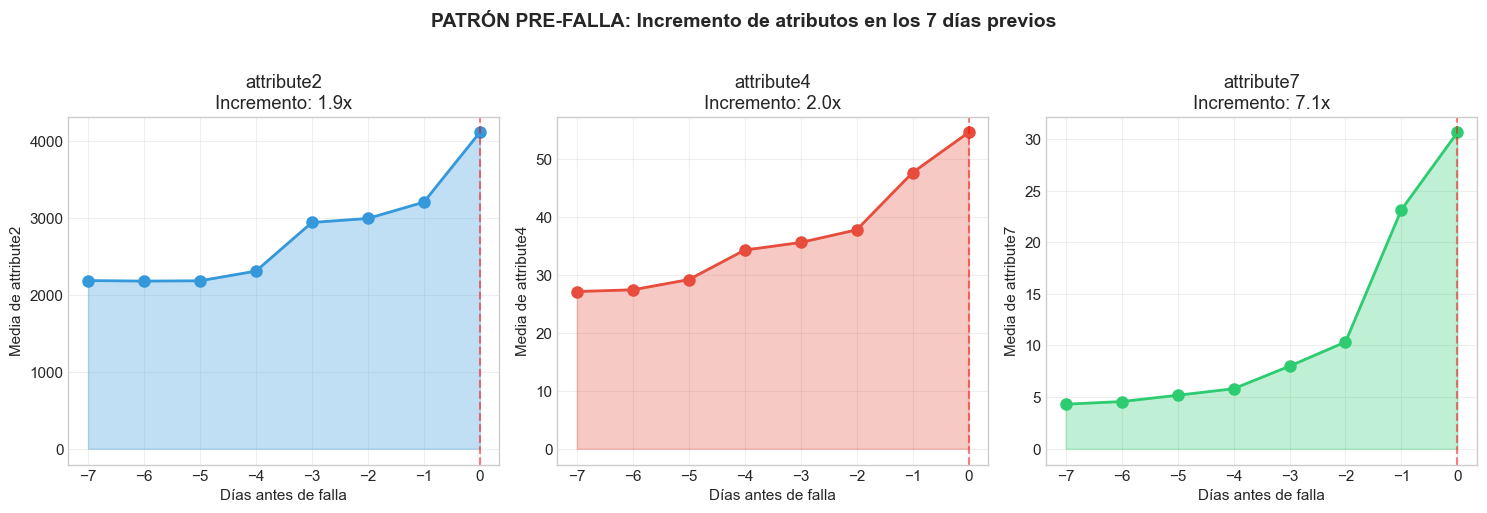

In [22]:
# Visualizar tendencia pre-falla
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#3498db', '#e74c3c', '#2ecc71']
days = list(range(-7, 1))

for ax, attr, color in zip(axes, key_attrs, colors):
    values = [trend_means.loc[d, attr] for d in days]
    ax.plot(days, values, marker='o', linewidth=2, markersize=8, color=color)
    ax.fill_between(days, values, alpha=0.3, color=color)
    ax.set_xlabel('Días antes de falla')
    ax.set_ylabel(f'Media de {attr}')
    ax.set_title(f'{attr}\nIncremento: {values[-1]/values[0]:.1f}x')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Día de falla')
    ax.set_xticks(days)
    ax.grid(True, alpha=0.3)

plt.suptitle('PATRÓN PRE-FALLA: Incremento de atributos en los 7 días previos', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Hallazgo Crítico

Los atributos 2, 4 y 7 muestran una **tendencia creciente** en los días previos a la falla:

- **attribute7**: Incremento de **7x** (de 4.3 a 30.6)
- **attribute4**: Incremento de **2x** (de 27 a 55)
- **attribute2**: Incremento de **1.9x** (de 2,185 a 4,109)

**Implicación para Feature Engineering**: Este patrón justifica crear features de:
- Rolling mean (3 y 7 días)
- Rolling std (variabilidad)
- Rate of change (diff, pct_change)

---
## 5. Análisis de Dispositivos

In [23]:
# Estadísticas de dispositivos
n_devices = df['device'].nunique()
n_failed_devices = len(failed_devices)

print(f'Total dispositivos únicos: {n_devices:,}')
print(f'Dispositivos que fallaron: {n_failed_devices:,} ({n_failed_devices/n_devices*100:.1f}%)')
print(f'Dispositivos sin fallas: {n_devices - n_failed_devices:,}')

Total dispositivos únicos: 1,169
Dispositivos que fallaron: 106 (9.1%)
Dispositivos sin fallas: 1,063


In [24]:
# Verificar fallas por dispositivo
failures_per_device = df.groupby('device')['failure'].sum()
print(f'\nFallas por dispositivo:')
print(f'  Máximo: {failures_per_device.max()}')
print(f'  → Cada dispositivo falla A LO SUMO 1 vez')


Fallas por dispositivo:
  Máximo: 1
  → Cada dispositivo falla A LO SUMO 1 vez


In [25]:
# Historial antes de falla
days_before_failure = []

for device in failed_devices:
    device_df = df[df['device'] == device].sort_values('date')
    failure_date = device_df[device_df['failure'] == 1]['date'].iloc[0]
    first_record = device_df['date'].min()
    days = (failure_date - first_record).days
    days_before_failure.append(days)

print('Días de historial antes de falla:')
print(f'  Media:   {np.mean(days_before_failure):.1f} días')
print(f'  Mediana: {np.median(days_before_failure):.1f} días')
print(f'  Mínimo:  {np.min(days_before_failure)} días')
print(f'  Máximo:  {np.max(days_before_failure)} días')
print(f'\n  → Suficiente historial para crear features de rolling (7 días)')

Días de historial antes de falla:
  Media:   106.9 días
  Mediana: 113.0 días
  Mínimo:  4 días
  Máximo:  298 días

  → Suficiente historial para crear features de rolling (7 días)


---
## 6. Features Recomendadas

Basándose en el análisis exploratorio, se recomienda crear las siguientes features:

### A. Eliminar

| Feature | Razón |
|---------|-------|
| `attribute8` | 100% idéntico a attribute7 |

### B. Features Temporales (para attribute2, attribute4, attribute7)

| Feature | Justificación |
|---------|---------------|
| `rolling_mean_3d` | Captura tendencia de corto plazo |
| `rolling_mean_7d` | Captura tendencia semanal |
| `rolling_std_7d` | Variabilidad como señal de anomalía |
| `diff_1d` | Tasa de cambio diaria |
| `pct_change_1d` | Cambio porcentual relativo |

### C. Features de Dispositivo

| Feature | Justificación |
|---------|---------------|
| `device_age` | Días desde primer registro |

### D. Features de Calendario

| Feature | Justificación |
|---------|---------------|
| `month` | Posibles patrones estacionales |
| `day_of_week` | Patrones semanales |